In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform
import itertools
# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             
import tqdm
# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages


### Create graph with navigation information

In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.4042418779,0],
    [0.79950060287,0], 
    [1.10492779947,0],
    [1.25764139777,0],
    [1.27560770345,0],
    [1.527135983,0],
    [1.69781588699,0], 
    [2.03019254211,0],
    [2.16493983473,0],
    [2.34460289155,0],
    [3.0093562018,0],
    [3.27885078704,0], 
    [3.36868231545,0],
    [4.06038508422,0],
    [4.06936823706,0], 
    [4.4915764206,0],
    [4.54547533765,0],
    [4.68022263026,0], 
    [5.04853189675,0],
    [5.2102286479,0],
    [5.68633574848,0],
    [6.1354933906,0],
    [6.5846510326,0], 
] 


# for each edge (between above coordinates) specify the depth (m)
depths = [
            7.5, 4.18, 4.18, 7.83,7.83, 
            7.5, 6.5, 10.6, 6.45, 8.04,
            8.04, 5.65, 8.87, 8.87, 4.93,
            4.93, 7.7,7.7, 9.8, 5.45, 5.45,5.45, 5.45
         ] # [m]

current_speeds = [
                    -2.24* 0.2777, -3.4* 0.2777, -4.93* 0.2777, -2.59* 0.2777, -2.59* 0.2777,
                    -3.26* 0.2777, -3.85* 0.2777, -1.87* 0.2777, -1.08* 0.2777, -2.83* 0.2777, 
                    -2.83* 0.2777, -4.99* 0.2777,  -2.89* 0.2777,  -2.89* 0.2777, -6.4* 0.2777,
                    -6.4* 0.2777, -3.42* 0.2777, -3.42* 0.2777, -1.64* 0.2777, -4.1* 0.2777, -4.1* 0.2777,-4.1* 0.2777, -4.1* 0.2777
                ]  # [m/s]

V_g_profile_up = [
                    3.33, 3.33, 3.33, 3.33, 3.33,   
                    3.33, 3.33, 3.33, 3.33, 3.33,
                    3.33, 3.33, 3.33, 3.33, 3.33,
                    3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33
                ] # [m/s] for upstream, 3.33 m/s = 12 km/h

V_g_profile_down = [
                     4.44, 4.44, 4.44, 4.44, 4.44, 
                     4.44, 4.44, 4.44, 4.44, 4.44, 
                     4.44, 4.44, 4.44, 4.44, 4.44, 
                     4.44, 4.44, 4.44, 3.33, 4.44, 4.44, 4.44, 4.44
                    ] # [m/s] for downstream, 4.44 m/s = 16 km/h


# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile_upstream": V_g_profile_up[index],
        "VesselSpeedToGroundProfile_downstream": V_g_profile_down[index]
    })

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

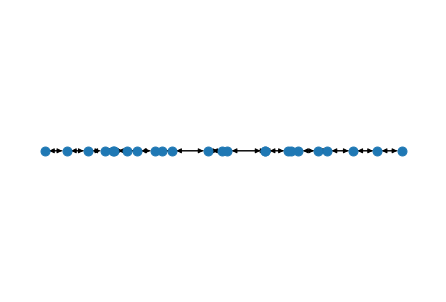

In [4]:
# show graph
nx.draw(FG, positions, node_size=80)

plt.show()

### Define the path 1 on the graph for energy use simulation

In [5]:
path_up_1_Budapest2Regensburg = nx.dijkstra_path(FG, nodes[23].name, nodes[0].name)

### Create vessel sailing on path 1 - add VesselProperties and ConsumesEnergy mixins

In [6]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

vessels sailing on path 1 include 17 vessel types sailing upstream loaded and ballast

In [7]:
# Create a dict with all important settings

data_vessel_MCV135_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV135_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 135,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1800,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [8]:
# Create a dict with all important settings

data_vessel_MCV135_up_ballast = {
    "env": None,
    "name": 'MCV135_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 135,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1800,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [9]:
# Create a dict with all important settings

data_vessel_MCV110_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV110_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [10]:
# Create a dict with all important settings

data_vessel_MCV110_up_ballast = {
    "env": None,
    "name": 'MCV110_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [11]:
# Create a dict with all important settings

data_vessel_MCV110_1B_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV110_1B_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 186.5,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [12]:
# Create a dict with all important settings

data_vessel_MCV110_1B_up_ballast = {
    "env": None,
    "name": 'MCV110_1B_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 186.5,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [13]:
# Create a dict with all important settings

data_vessel_MCV105_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV105_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 105,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":950,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [14]:
# Create a dict with all important settings

data_vessel_MCV105_up_ballast = {
    "env": None,
    "name": 'MCV105_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 105,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 950,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [15]:
# Create a dict with all important settings

data_vessel_MCV95_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV95_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11,
    "L": 95,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1300,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [16]:
# Create a dict with all important settings

data_vessel_MCV95_up_ballast = {
    "env": None,
    "name": 'MCV95_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11,
    "L": 95,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1300,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [17]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV85_9_5_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [18]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_up_ballast = {
    "env": None,
    "name": 'MCV85_9_5_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [19]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_1B_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV135_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 161.5,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [20]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_1B_up_ballast = {
    "env": None,
    "name": 'MCV135_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 161.5,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [21]:
# Create a dict with all important settings

data_vessel_MCV85_8_2_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV85_8_2_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 8.2,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [22]:
# Create a dict with all important settings

data_vessel_MCV85_8_2_up_ballast = {
    "env": None,
    "name": 'MCV85_8_2_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 8.2,
    "L": 85,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [23]:
# Create a dict with all important settings

data_vessel_MCV80_8_2_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV80_8_2_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 8.2,
    "L": 80,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [24]:
# Create a dict with all important settings

data_vessel_MCV80_8_2_up_ballast = {
    "env": None,
    "name": 'MCV80_8_2_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 8.2,
    "L": 80,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [25]:
# Create a dict with all important settings

data_vessel_MTV110_up_loaded_MHWL = {
    "env": None,
    "name": 'MTV110_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [26]:
# Create a dict with all important settings

data_vessel_MTV110_up_ballast = {
    "env": None,
    "name": 'MTV110_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [27]:
# Create a dict with all important settings

data_vessel_MTV110_1B_up_loaded_MHWL = {
    "env": None,
    "name": 'MTV110_1B_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 186.5,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [28]:
# Create a dict with all important settings

data_vessel_MTV110_1B_up_ballast = {
    "env": None,
    "name": 'MTV110_1B_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 186.5,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [29]:
# Create a dict with all important settings

data_vessel_MTV85_up_loaded_MHWL = {
    "env": None,
    "name": 'MTV85_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [30]:
# Create a dict with all important settings

data_vessel_MTV85_up_ballast = {
    "env": None,
    "name": 'MTV85_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [31]:
# Create a dict with all important settings

data_vessel_PUSH23_1B_up_loaded_MHWL = {
    "env": None,
    "name": 'PUSH23_1B_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 99.5,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [32]:
# Create a dict with all important settings

data_vessel_PUSH23_1B_up_ballast = {
    "env": None,
    "name": 'PUSH23_1B_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 99.5,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [33]:
# Create a dict with all important settings

data_vessel_PUSH23_2B_up_loaded_MHWL = {
    "env": None,
    "name": 'PUSH23_2B_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 176,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [34]:
# Create a dict with all important settings

data_vessel_PUSH23_2B_up_ballast = {
    "env": None,
    "name": 'PUSH23_2B_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 176,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [35]:
# Create a dict with all important settings

data_vessel_PUSH35_2B_up_loaded_MHWL = {
    "env": None,
    "name": 'PUSH35_2B_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 188,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1700,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [36]:
# Create a dict with all important settings

data_vessel_PUSH35_2B_up_ballast = {
    "env": None,
    "name": 'PUSH35_2B_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 188,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1700,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [37]:
# Create a dict with all important settings

data_vessel_PUSH35_4B_up_loaded_MHWL = {
    "env": None,
    "name": 'PUSH35_4B_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 188,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":2500,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [38]:
# Create a dict with all important settings

data_vessel_PUSH35_4B_up_ballast = {
    "env": None,
    "name": 'PUSH35_4B_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 188,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 2500,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [39]:
# Create a dict with all important settings

data_vessel_PUSH57_2B_up_loaded_MHWL = {
    "env": None,
    "name": 'PUSH57_2B_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 210,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1470,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [40]:
# Create a dict with all important settings

data_vessel_PUSH57_2B_up_ballast = {
    "env": None,
    "name": 'PUSH57_2B_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 210,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1470,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



### Define simulation

define basic simulation for vessel moving and consuming energy

In [41]:
def run_simulation(path,**data_vessel):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    # vessel.V_g_ave = V_g_ave
    # vessel.sailing_upstream = sailing_upstream
    # vessel.P_tot_given = P_tot_given
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

define specific vessel simulation with vessel type and number of trips

In [42]:
def get_energy(nr_trips, path,**data_vessel):
    vessel = run_simulation(path,**data_vessel)
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel=vessel)
    energycalculation.calculate_energy_consumption()
    
    df = pd.DataFrame.from_dict(energycalculation.energy_use)
    
    # selected = ['edge_start','edge_stop','distance','total_energy','total_H2_350bar_PEMFC_mass','total_H2_350bar_PEMFC_40ft_containers']
    # df_energy = df[selected]
    # df_energy['distance_km_cum']=df_energy['distance'].cumsum()/1000
    # df_energy['total_trips_energy'] = df_energy['total_energy']*nr_trips
    # df_energy['total_trips_H2_350bar_PEMFC_mass_ton'] = df_energy['total_H2_350bar_PEMFC_mass']*nr_trips/1000000
    # df_energy['total_trips_H2_350bar_PEMFC_40ft_containers'] = df_energy['total_H2_350bar_PEMFC_40ft_containers']*nr_trips
    # df_energy['energy_consumption_kWh_cum'] = df_energy['total_energy'].cumsum()
    # df_energy['total_H2_350bar_PEMFC_mass_cum_ton'] = df_energy['total_H2_350bar_PEMFC_mass'].cumsum()/1000000
    # df_energy['total_H2_350bar_PEMFC_40ft_containers_cum'] = df_energy['total_H2_350bar_PEMFC_40ft_containers'].cumsum()
    # df_energy['total_trips_H2_350bar_PEMFC_mass_cum_ton'] = df_energy['total_trips_H2_350bar_PEMFC_mass_ton'].cumsum()
    # df_energy['total_trips_H2_350bar_PEMFC_40ft_containers_cum'] = df_energy['total_trips_H2_350bar_PEMFC_40ft_containers'].cumsum()
    selected = ['distance','total_H2_500bar_PEMFC_40ft_containers']
    df_energy = df[selected]
    df_energy['distance_km_cum']=df_energy['distance'].cumsum()/1000
    # df_energy['total_trips_energy'] = df_energy['total_energy']*nr_trips
    # df_energy['total_trips_H2_350bar_PEMFC_mass_ton'] = df_energy['total_H2_350bar_PEMFC_mass']*nr_trips/1000000
    # df_energy['total_trips_H2_350bar_PEMFC_40ft_containers'] = df_energy['total_H2_350bar_PEMFC_40ft_containers']*nr_trips
    # df_energy['energy_consumption_kWh_cum'] = df_energy['total_energy'].cumsum()
    # df_energy['total_H2_350bar_PEMFC_mass_cum_ton'] = df_energy['total_H2_350bar_PEMFC_mass'].cumsum()/1000000
    df_energy['total_H2_500bar_PEMFC_40ft_containers_cum'] = df_energy['total_H2_500bar_PEMFC_40ft_containers'].cumsum()
    # df_energy['total_trips_H2_350bar_PEMFC_mass_cum_ton'] = df_energy['total_trips_H2_350bar_PEMFC_mass_ton'].cumsum()
    # df_energy['total_trips_H2_350bar_PEMFC_40ft_containers_cum'] = df_energy['total_trips_H2_350bar_PEMFC_40ft_containers'].cumsum()
    
    return df_energy

In [43]:
energy_MCV135_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV135_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV135_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.227156,50.0,0.227156
1,50000.000007,0.227156,100.0,0.454311
2,53000.000000,0.240785,153.0,0.695096
3,18000.000001,0.081776,171.0,0.776872
4,41000.000000,0.083953,212.0,0.860825
5,14999.999999,0.048203,227.0,0.909028
6,6000.000000,0.019281,233.0,0.928309
7,47000.000000,0.527063,280.0,1.455372
8,1000.000000,0.011214,281.0,1.466586
9,77000.000000,0.208771,358.0,1.675357


In [44]:
energy_MCV135_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV135_up_ballast)
# pd.options.display.max_columns = None
energy_MCV135_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.307067,50.0,0.307067
1,50000.000007,0.307067,100.0,0.614134
2,53000.000000,0.325491,153.0,0.939625
3,18000.000001,0.110544,171.0,1.050169
4,41000.000000,0.113761,212.0,1.163931
5,14999.999999,0.068771,227.0,1.232701
6,6000.000000,0.027508,233.0,1.260209
7,47000.000000,0.602844,280.0,1.863053
8,1000.000000,0.012826,281.0,1.875879
9,77000.000000,0.299021,358.0,2.174900


In [45]:
energy_MCV110_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV110_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV110_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.202666,50.0,0.202666
1,50000.000007,0.202666,100.0,0.405332
2,53000.000000,0.214826,153.0,0.620158
3,18000.000001,0.072960,171.0,0.693118
4,41000.000000,0.072838,212.0,0.765955
5,14999.999999,0.042776,227.0,0.808732
6,6000.000000,0.017111,233.0,0.825842
7,47000.000000,0.385150,280.0,1.210992
8,1000.000000,0.008195,281.0,1.219187
9,77000.000000,0.182792,358.0,1.401979


In [46]:
energy_MCV110_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV110_up_ballast)
# pd.options.display.max_columns = None
energy_MCV110_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.199496,50.0,0.199496
1,50000.000007,0.199496,100.0,0.398991
2,53000.000000,0.211465,153.0,0.610457
3,18000.000001,0.071818,171.0,0.682275
4,41000.000000,0.073603,212.0,0.755879
5,14999.999999,0.044096,227.0,0.799974
6,6000.000000,0.017638,233.0,0.817612
7,47000.000000,0.385150,280.0,1.202762
8,1000.000000,0.008195,281.0,1.210957
9,77000.000000,0.192099,358.0,1.403057


In [47]:
energy_MCV110_1B_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV110_1B_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV110_1B_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.409205,50.0,0.409205
1,50000.000007,0.409205,100.0,0.818411
2,53000.000000,0.433758,153.0,1.252169
3,18000.000001,0.147314,171.0,1.399483
4,41000.000000,0.133007,212.0,1.532490
5,14999.999999,0.084374,227.0,1.616863
6,6000.000000,0.033749,233.0,1.650613
7,47000.000000,0.385150,280.0,2.035763
8,1000.000000,0.008195,281.0,2.043957
9,77000.000000,0.349439,358.0,2.393396


In [48]:
energy_MCV110_1B_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV110_1B_up_ballast)
# pd.options.display.max_columns = None
energy_MCV110_1B_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.409734,50.0,0.409734
1,50000.000007,0.409734,100.0,0.819468
2,53000.000000,0.434318,153.0,1.253786
3,18000.000001,0.147504,171.0,1.401291
4,41000.000000,0.335982,212.0,1.737273
5,14999.999999,0.122920,227.0,1.860193
6,6000.000000,0.049168,233.0,1.909361
7,47000.000000,0.385150,280.0,2.294511
8,1000.000000,0.008195,281.0,2.302706
9,77000.000000,0.630991,358.0,2.933696


In [49]:
energy_MCV105_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV105_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV105_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.196308,50.0,0.196308
1,50000.000007,0.196308,100.0,0.392616
2,53000.000000,0.208086,153.0,0.600702
3,18000.000001,0.070671,171.0,0.671373
4,41000.000000,0.071905,212.0,0.743278
5,14999.999999,0.041453,227.0,0.784731
6,6000.000000,0.016581,233.0,0.801313
7,47000.000000,0.318167,280.0,1.119480
8,1000.000000,0.006770,281.0,1.126250
9,77000.000000,0.183789,358.0,1.310038


In [50]:
energy_MCV105_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV105_up_ballast)
# pd.options.display.max_columns = None
energy_MCV105_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.187895,50.0,0.187895
1,50000.000007,0.187895,100.0,0.375790
2,53000.000000,0.199169,153.0,0.574959
3,18000.000001,0.067642,171.0,0.642601
4,41000.000000,0.070517,212.0,0.713118
5,14999.999999,0.041380,227.0,0.754498
6,6000.000000,0.016552,233.0,0.771050
7,47000.000000,0.318167,280.0,1.089218
8,1000.000000,0.006770,281.0,1.095987
9,77000.000000,0.185281,358.0,1.281268


In [51]:
energy_MCV95_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV95_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV95_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.158721,50.0,0.158721
1,50000.000007,0.158721,100.0,0.317443
2,53000.000000,0.168245,153.0,0.485688
3,18000.000001,0.057140,171.0,0.542827
4,41000.000000,0.059646,212.0,0.602473
5,14999.999999,0.034102,227.0,0.636575
6,6000.000000,0.013641,233.0,0.650215
7,47000.000000,0.399528,280.0,1.049744
8,1000.000000,0.008501,281.0,1.058244
9,77000.000000,0.149395,358.0,1.207639


In [52]:
energy_MCV95_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV95_up_ballast)
# pd.options.display.max_columns = None
energy_MCV95_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.153602,50.0,0.153602
1,50000.000007,0.153602,100.0,0.307204
2,53000.000000,0.162818,153.0,0.470022
3,18000.000001,0.055297,171.0,0.525319
4,41000.000000,0.059497,212.0,0.584816
5,14999.999999,0.034323,227.0,0.619139
6,6000.000000,0.013729,233.0,0.632868
7,47000.000000,0.337441,280.0,0.970308
8,1000.000000,0.007180,281.0,0.977488
9,77000.000000,0.150737,358.0,1.128225


In [53]:
energy_MCV85_9_5_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV85_9_5_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV85_9_5_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.134919,50.0,0.134919
1,50000.000007,0.134919,100.0,0.269838
2,53000.000000,0.143014,153.0,0.412853
3,18000.000001,0.048571,171.0,0.461423
4,41000.000000,0.049669,212.0,0.511093
5,14999.999999,0.028918,227.0,0.540011
6,6000.000000,0.011567,233.0,0.551578
7,47000.000000,0.251185,280.0,0.802763
8,1000.000000,0.005344,281.0,0.808107
9,77000.000000,0.126765,358.0,0.934873


In [54]:
energy_MCV85_9_5_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV85_9_5_up_ballast)
# pd.options.display.max_columns = None
energy_MCV85_9_5_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.126945,50.0,0.126945
1,50000.000007,0.126945,100.0,0.253889
2,53000.000000,0.134561,153.0,0.388451
3,18000.000001,0.045700,171.0,0.434151
4,41000.000000,0.048390,212.0,0.482541
5,14999.999999,0.028345,227.0,0.510885
6,6000.000000,0.011338,233.0,0.522223
7,47000.000000,0.251185,280.0,0.773408
8,1000.000000,0.005344,281.0,0.778752
9,77000.000000,0.124207,358.0,0.902960


In [55]:
energy_MCV85_9_5_1B_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV85_9_5_1B_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV85_9_5_1B_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.267218,50.0,0.267218
1,50000.000007,0.267218,100.0,0.534436
2,53000.000000,0.283251,153.0,0.817687
3,18000.000001,0.096198,171.0,0.913885
4,41000.000000,0.122000,212.0,1.035885
5,14999.999999,0.075571,227.0,1.111456
6,6000.000000,0.030228,233.0,1.141684
7,47000.000000,0.251185,280.0,1.392869
8,1000.000000,0.005344,281.0,1.398213
9,77000.000000,0.322864,358.0,1.721078


In [56]:
energy_MCV85_9_5_1B_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV85_9_5_1B_up_ballast)
# pd.options.display.max_columns = None
energy_MCV85_9_5_1B_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.267218,50.0,0.267218
1,50000.000007,0.267218,100.0,0.534436
2,53000.000000,0.283251,153.0,0.817687
3,18000.000001,0.096198,171.0,0.913885
4,41000.000000,0.219119,212.0,1.133004
5,14999.999999,0.080165,227.0,1.213169
6,6000.000000,0.032066,233.0,1.245235
7,47000.000000,0.251185,280.0,1.496420
8,1000.000000,0.005344,281.0,1.501765
9,77000.000000,0.411516,358.0,1.913280


In [57]:
energy_MCV85_8_2_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV85_8_2_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV85_8_2_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.118224,50.0,0.118224
1,50000.000007,0.118224,100.0,0.236448
2,53000.000000,0.125318,153.0,0.361766
3,18000.000001,0.042561,171.0,0.404326
4,41000.000000,0.044539,212.0,0.448865
5,14999.999999,0.025450,227.0,0.474315
6,6000.000000,0.010180,233.0,0.484495
7,47000.000000,0.200948,280.0,0.685443
8,1000.000000,0.004275,281.0,0.689719
9,77000.000000,0.114354,358.0,0.804073


In [58]:
energy_MCV85_8_2_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV85_8_2_up_ballast)
# pd.options.display.max_columns = None
energy_MCV85_8_2_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.111717,50.0,0.111717
1,50000.000007,0.111717,100.0,0.223435
2,53000.000000,0.118420,153.0,0.341855
3,18000.000001,0.040218,171.0,0.382073
4,41000.000000,0.043372,212.0,0.425446
5,14999.999999,0.024805,227.0,0.450251
6,6000.000000,0.009922,233.0,0.460173
7,47000.000000,0.200948,280.0,0.661121
8,1000.000000,0.004275,281.0,0.665396
9,77000.000000,0.111642,358.0,0.777038


In [59]:
energy_MCV80_8_2_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV80_8_2_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV80_8_2_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.114344,50.0,0.114344
1,50000.000007,0.114344,100.0,0.228687
2,53000.000000,0.121204,153.0,0.349892
3,18000.000001,0.041164,171.0,0.391056
4,41000.000000,0.042710,212.0,0.433766
5,14999.999999,0.024495,227.0,0.458260
6,6000.000000,0.009798,233.0,0.468058
7,47000.000000,0.200948,280.0,0.669006
8,1000.000000,0.004275,281.0,0.673282
9,77000.000000,0.109380,358.0,0.782661


In [60]:
energy_MCV80_8_2_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV80_8_2_up_ballast)
# pd.options.display.max_columns = None
energy_MCV80_8_2_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.106770,50.0,0.106770
1,50000.000007,0.106770,100.0,0.213540
2,53000.000000,0.113176,153.0,0.326716
3,18000.000001,0.038437,171.0,0.365153
4,41000.000000,0.041103,212.0,0.406256
5,14999.999999,0.023734,227.0,0.429990
6,6000.000000,0.009494,233.0,0.439484
7,47000.000000,0.200948,280.0,0.640432
8,1000.000000,0.004275,281.0,0.644707
9,77000.000000,0.105352,358.0,0.750060


In [61]:
energy_MTV110_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MTV110_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MTV110_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.202666,50.0,0.202666
1,50000.000007,0.202666,100.0,0.405332
2,53000.000000,0.214826,153.0,0.620158
3,18000.000001,0.072960,171.0,0.693118
4,41000.000000,0.072838,212.0,0.765955
5,14999.999999,0.042776,227.0,0.808732
6,6000.000000,0.017111,233.0,0.825842
7,47000.000000,0.385150,280.0,1.210992
8,1000.000000,0.008195,281.0,1.219187
9,77000.000000,0.182792,358.0,1.401979


In [62]:
energy_MTV110_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MTV110_up_ballast)
# pd.options.display.max_columns = None
energy_MTV110_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.199496,50.0,0.199496
1,50000.000007,0.199496,100.0,0.398991
2,53000.000000,0.211465,153.0,0.610457
3,18000.000001,0.071818,171.0,0.682275
4,41000.000000,0.073603,212.0,0.755879
5,14999.999999,0.044096,227.0,0.799974
6,6000.000000,0.017638,233.0,0.817612
7,47000.000000,0.385150,280.0,1.202762
8,1000.000000,0.008195,281.0,1.210957
9,77000.000000,0.192099,358.0,1.403057


In [63]:
energy_MTV110_1B_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MTV110_1B_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MTV110_1B_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.409205,50.0,0.409205
1,50000.000007,0.409205,100.0,0.818411
2,53000.000000,0.433758,153.0,1.252169
3,18000.000001,0.147314,171.0,1.399483
4,41000.000000,0.133007,212.0,1.532490
5,14999.999999,0.084374,227.0,1.616863
6,6000.000000,0.033749,233.0,1.650613
7,47000.000000,0.385150,280.0,2.035763
8,1000.000000,0.008195,281.0,2.043957
9,77000.000000,0.349439,358.0,2.393396


In [64]:
energy_MTV110_1B_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MTV110_1B_up_ballast)
# pd.options.display.max_columns = None
energy_MTV110_1B_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.409734,50.0,0.409734
1,50000.000007,0.409734,100.0,0.819468
2,53000.000000,0.434318,153.0,1.253786
3,18000.000001,0.147504,171.0,1.401291
4,41000.000000,0.335982,212.0,1.737273
5,14999.999999,0.122920,227.0,1.860193
6,6000.000000,0.049168,233.0,1.909361
7,47000.000000,0.385150,280.0,2.294511
8,1000.000000,0.008195,281.0,2.302706
9,77000.000000,0.630991,358.0,2.933696


In [65]:
energy_MTV85_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MTV85_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MTV85_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.134919,50.0,0.134919
1,50000.000007,0.134919,100.0,0.269838
2,53000.000000,0.143014,153.0,0.412853
3,18000.000001,0.048571,171.0,0.461423
4,41000.000000,0.049669,212.0,0.511093
5,14999.999999,0.028918,227.0,0.540011
6,6000.000000,0.011567,233.0,0.551578
7,47000.000000,0.251185,280.0,0.802763
8,1000.000000,0.005344,281.0,0.808107
9,77000.000000,0.126765,358.0,0.934873


In [66]:
energy_MTV85_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MTV85_up_ballast)
# pd.options.display.max_columns = None
energy_MTV85_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.126945,50.0,0.126945
1,50000.000007,0.126945,100.0,0.253889
2,53000.000000,0.134561,153.0,0.388451
3,18000.000001,0.045700,171.0,0.434151
4,41000.000000,0.048390,212.0,0.482541
5,14999.999999,0.028345,227.0,0.510885
6,6000.000000,0.011338,233.0,0.522223
7,47000.000000,0.251185,280.0,0.773408
8,1000.000000,0.005344,281.0,0.778752
9,77000.000000,0.124207,358.0,0.902960


In [67]:
energy_PUSH23_1B_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_PUSH23_1B_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH23_1B_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.189985,50.0,0.189985
1,50000.000007,0.189985,100.0,0.379971
2,53000.000000,0.201385,153.0,0.581356
3,18000.000001,0.068395,171.0,0.649750
4,41000.000000,0.068921,212.0,0.718672
5,14999.999999,0.040006,227.0,0.758678
6,6000.000000,0.016003,233.0,0.774680
7,47000.000000,0.334913,280.0,1.109594
8,1000.000000,0.007126,281.0,1.116719
9,77000.000000,0.174408,358.0,1.291127


In [68]:
energy_PUSH23_1B_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_PUSH23_1B_up_ballast)
# pd.options.display.max_columns = None
energy_PUSH23_1B_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.176037,50.0,0.176037
1,50000.000007,0.176037,100.0,0.352074
2,53000.000000,0.186599,153.0,0.538673
3,18000.000001,0.063373,171.0,0.602046
4,41000.000000,0.065423,212.0,0.667470
5,14999.999999,0.038822,227.0,0.706292
6,6000.000000,0.015529,233.0,0.721820
7,47000.000000,0.334913,280.0,1.056733
8,1000.000000,0.007126,281.0,1.063859
9,77000.000000,0.169909,358.0,1.233768


In [69]:
energy_PUSH23_2B_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_PUSH23_2B_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH23_2B_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.356291,50.0,0.356291
1,50000.000007,0.356291,100.0,0.712581
2,53000.000000,0.377668,153.0,1.090249
3,18000.000001,0.128265,171.0,1.218514
4,41000.000000,0.119721,212.0,1.338235
5,14999.999999,0.075650,227.0,1.413885
6,6000.000000,0.030260,233.0,1.444144
7,47000.000000,0.334913,280.0,1.779058
8,1000.000000,0.007126,281.0,1.786183
9,77000.000000,0.313534,358.0,2.099718


In [70]:
energy_PUSH23_2B_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_PUSH23_2B_up_ballast)
# pd.options.display.max_columns = None
energy_PUSH23_2B_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.356291,50.0,0.356291
1,50000.000007,0.356291,100.0,0.712581
2,53000.000000,0.377668,153.0,1.090249
3,18000.000001,0.128265,171.0,1.218514
4,41000.000000,0.292158,212.0,1.510672
5,14999.999999,0.106887,227.0,1.617559
6,6000.000000,0.042755,233.0,1.660314
7,47000.000000,0.334913,280.0,1.995227
8,1000.000000,0.007126,281.0,2.002353
9,77000.000000,0.548687,358.0,2.551040


In [71]:
energy_PUSH35_2B_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_PUSH35_2B_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH35_2B_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.390800,50.0,0.390800
1,50000.000007,0.390800,100.0,0.781601
2,53000.000000,0.414248,153.0,1.195849
3,18000.000001,0.140688,171.0,1.336537
4,41000.000000,0.130249,212.0,1.466786
5,14999.999999,0.077201,227.0,1.543986
6,6000.000000,0.030880,233.0,1.574867
7,47000.000000,0.569352,280.0,2.144219
8,1000.000000,0.012114,281.0,2.156333
9,77000.000000,0.339715,358.0,2.496048


In [72]:
energy_PUSH35_2B_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_PUSH35_2B_up_ballast)
# pd.options.display.max_columns = None
energy_PUSH35_2B_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.605694,50.0,0.605694
1,50000.000007,0.605694,100.0,1.211388
2,53000.000000,0.642036,153.0,1.853423
3,18000.000001,0.218050,171.0,2.071473
4,41000.000000,0.496669,212.0,2.568142
5,14999.999999,0.181708,227.0,2.749850
6,6000.000000,0.072683,233.0,2.822534
7,47000.000000,0.569352,280.0,3.391886
8,1000.000000,0.012114,281.0,3.404000
9,77000.000000,0.932769,358.0,4.336768


In [73]:
energy_PUSH35_4B_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_PUSH35_4B_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH35_4B_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.750911,50.0,0.750911
1,50000.000007,0.750911,100.0,1.501822
2,53000.000000,0.795966,153.0,2.297788
3,18000.000001,0.270328,171.0,2.568116
4,41000.000000,0.220646,212.0,2.788762
5,14999.999999,0.142142,227.0,2.930904
6,6000.000000,0.056857,233.0,2.987760
7,47000.000000,0.837283,280.0,3.825043
8,1000.000000,0.017815,281.0,3.842858
9,77000.000000,0.585311,358.0,4.428168


In [74]:
energy_PUSH35_4B_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_PUSH35_4B_up_ballast)
# pd.options.display.max_columns = None
energy_PUSH35_4B_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.890726,50.0,0.890726
1,50000.000007,0.890726,100.0,1.781453
2,53000.000000,0.944170,153.0,2.725623
3,18000.000001,0.320661,171.0,3.046284
4,41000.000000,0.730396,212.0,3.776680
5,14999.999999,0.267218,227.0,4.043898
6,6000.000000,0.106887,233.0,4.150785
7,47000.000000,0.837283,280.0,4.988068
8,1000.000000,0.017815,281.0,5.005882
9,77000.000000,1.371719,358.0,6.377601


In [75]:
energy_PUSH57_2B_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_PUSH57_2B_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH57_2B_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.523747,50.0,0.523747
1,50000.000007,0.523747,100.0,1.047494
2,53000.000000,0.555172,153.0,1.602666
3,18000.000001,0.188549,171.0,1.791215
4,41000.000000,0.194498,212.0,1.985713
5,14999.999999,0.119747,227.0,2.105460
6,6000.000000,0.047899,233.0,2.153359
7,47000.000000,0.492322,280.0,2.645681
8,1000.000000,0.010475,281.0,2.656156
9,77000.000000,0.523971,358.0,3.180127


In [76]:
energy_PUSH57_2B_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_PUSH57_2B_up_ballast)
# pd.options.display.max_columns = None
energy_PUSH57_2B_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_13576\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,49999.999993,0.523747,50.0,0.523747
1,50000.000007,0.523747,100.0,1.047494
2,53000.000000,0.555172,153.0,1.602666
3,18000.000001,0.188549,171.0,1.791215
4,41000.000000,0.429473,212.0,2.220688
5,14999.999999,0.157124,227.0,2.377812
6,6000.000000,0.062850,233.0,2.440661
7,47000.000000,0.492322,280.0,2.932984
8,1000.000000,0.010475,281.0,2.943459
9,77000.000000,0.806571,358.0,3.750029
